# Goal: Build a system to predict fake news

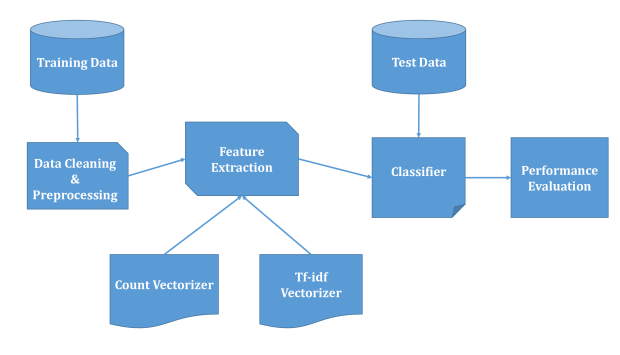

In [1]:
from IPython.display import Image
Image(filename="C:/Users/ranja/Desktop/project/diagram.png")

###### Dataset used - https://www.kaggle.com/

##### Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article
* label: a label that marks the article as potentially fake/real
  * 1: fake
  * 0: real

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

submit.csv: A sample file to see prediction results

#### Importing all the required libraries

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt

import re #Regular expressions 
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
#from sklearn.linear_model import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from prettytable import PrettyTable
import itertools
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Printing the stopwords in English
# We will have to remove these from the corpus during our analysis and pre-processing
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Data Pre-processing and Analysis

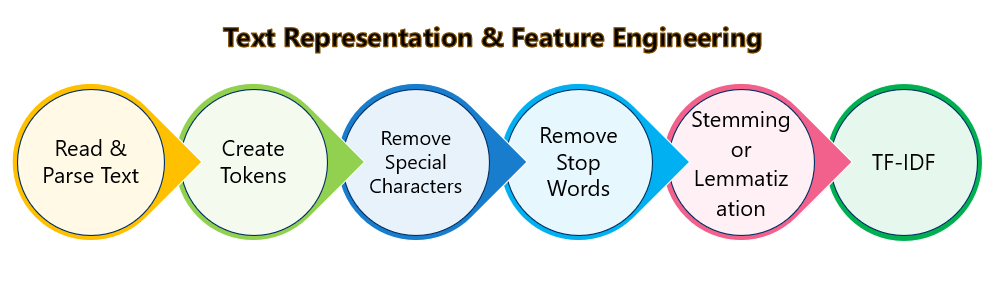

In [8]:
from IPython.display import Image
Image(filename="C:/Users/ranja/Desktop/project/text representation and tokenization.png")

##### Loading and exploratory data analysis : visualize the proportion of real and fake news.

In [9]:
data = pd.read_csv('C:/Users/ranja/Desktop/project/train.csv')
conversion_dict = {0: 'Real', 1: 'Fake'}
data['label'] = data['label'].replace(conversion_dict)
data.label.value_counts()


Fake    10413
Real    10387
Name: label, dtype: int64

In [11]:
import plotly.express as px

In [12]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Fake
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,Real
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Fake
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,Fake
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Fake


In [13]:
label = ['Real', 'Fake']
y1 = [10413, 10387]

In [14]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

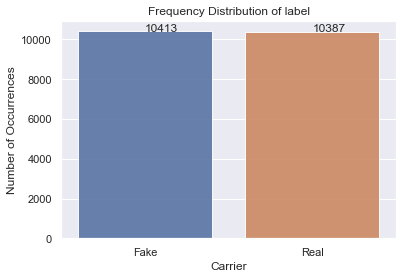

In [15]:
%matplotlib inline
carrier_count = data["label"].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of label')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
addlabels(label, y1) # calling the function to add lables
plt.show()

In [16]:
type(carrier_count)

pandas.core.series.Series

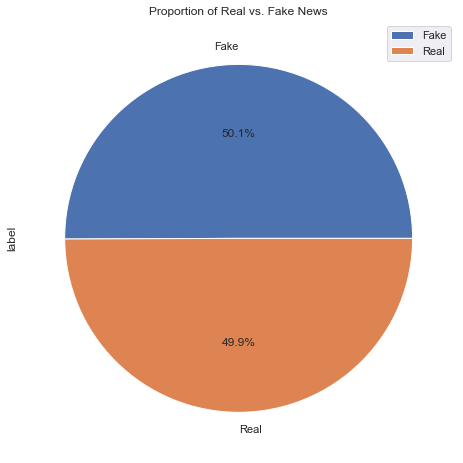

In [17]:
plt.title('Proportion of Real vs. Fake News')
data["label"].value_counts().head(3).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

##### Visualizing top 10 Authors :-

In [18]:
import seaborn as sns 
import matplotlib.pyplot as plt

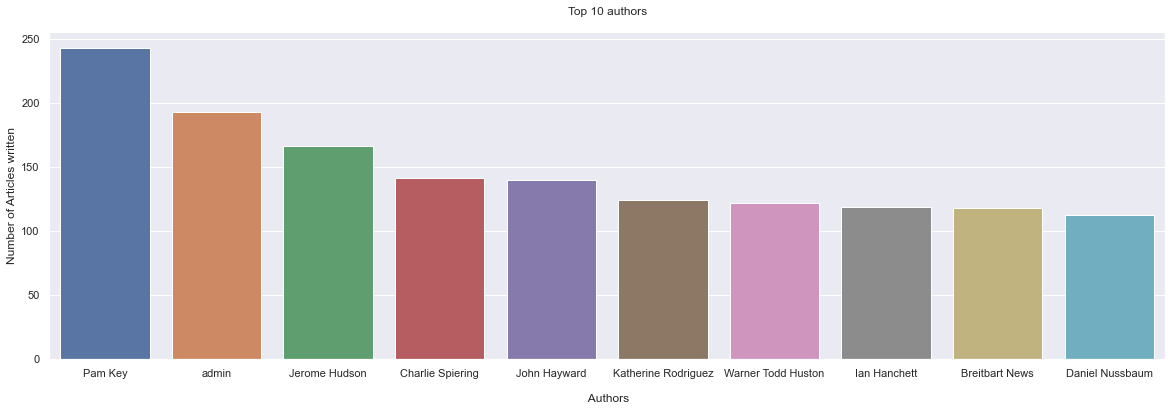

In [19]:
d = data['author'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 5 authors

# Plotting
sns.set()
plt.figure(figsize=(20,6))
sns.barplot(x='index', y='author', data=d)
plt.xlabel("\n Authors")
plt.ylabel("Number of Articles written")
plt.title("Top 10 authors\n")
plt.show()

###### Checking for missing values

In [20]:
data.isnull().sum() # missing values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

###### replacing the null values with empty strings

In [21]:
 #replacing missing values
data = data.fillna('') 
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

#### we are using field text description to train our model to help predict if it is real or fake news.

In [22]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Fake
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,Real
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Fake
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,Fake
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Fake


In [23]:
# Now we will separate the data and label i.e. text corpus and label fields
X = data.drop(columns='label', axis=1)
Y = data['label']

In [24]:
X = data['text']
print(X)

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        Ever get the feeling your life circles the rou...
2        Why the Truth Might Get You Fired October 29, ...
3        Videos 15 Civilians Killed In Single US Airstr...
4        Print \nAn Iranian woman has been sentenced to...
                               ...                        
20795    Rapper T. I. unloaded on black celebrities who...
20796    When the Green Bay Packers lost to the Washing...
20797    The Macy’s of today grew from the union of sev...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799      David Swanson is an author, activist, journa...
Name: text, Length: 20800, dtype: object


In [25]:
print(Y)

0        Fake
1        Real
2        Fake
3        Fake
4        Fake
         ... 
20795    Real
20796    Real
20797    Real
20798    Fake
20799    Fake
Name: label, Length: 20800, dtype: object


In [26]:
X.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    Ever get the feeling your life circles the rou...
2    Why the Truth Might Get You Fired October 29, ...
3    Videos 15 Civilians Killed In Single US Airstr...
4    Print \nAn Iranian woman has been sentenced to...
Name: text, dtype: object

### removing special characters, stopwords, applying Stemming & Tf-IDF

In [27]:
ps = PorterStemmer()

def stemming(corpus):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_corpus = re.sub('[^a-zA-Z]',' ',corpus)
    
    # Converting all letters to lowercase 
    stemmed_corpus = stemmed_corpus.lower()
    
    # Converting all to a splitted case or a list
    stemmed_corpus = stemmed_corpus.split()
    
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_corpus = [ps.stem(word) for word in stemmed_corpus] #if not word in stopwords.words('english')]
    
    # Join all the words in final content
    stemmed_corpus = ' '.join(stemmed_corpus)
    return stemmed_corpus

In [28]:
data['text'] = data['text'].apply(stemming)

In [29]:
print(data['text'])

0        hous dem aid we didn t even see comey s letter...
1        ever get the feel your life circl the roundabo...
2        whi the truth might get you fire octob the ten...
3        video civilian kill in singl us airstrik have ...
4        print an iranian woman ha been sentenc to six ...
                               ...                        
20795    rapper t i unload on black celebr who met with...
20796    when the green bay packer lost to the washingt...
20797    the maci s of today grew from the union of sev...
20798    nato russia to hold parallel exercis in balkan...
20799    david swanson is an author activist journalist...
Name: text, Length: 20800, dtype: object


In [30]:
# Separating data and label
X = data['text'].values
Y = data['label'].values

In [31]:
type(X)

numpy.ndarray

In [32]:
Y

array(['Fake', 'Real', 'Fake', ..., 'Real', 'Fake', 'Fake'], dtype=object)

In [33]:
#TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(X)
X = vectorizer.transform(X)

In [34]:
print(X)

  (0, 108536)	0.05183972338761873
  (0, 108483)	0.020147986336821775
  (0, 107539)	0.046669195480260585
  (0, 107535)	0.10014398078143699
  (0, 107492)	0.039886616369560625
  (0, 107455)	0.011940168346302193
  (0, 106813)	0.01816137665751448
  (0, 106025)	0.018049110371599602
  (0, 105853)	0.030825798972738558
  (0, 105777)	0.013581650514299144
  (0, 105578)	0.012445635221546417
  (0, 104914)	0.06467404360702042
  (0, 104738)	0.027326694690594226
  (0, 104703)	0.03309235726262687
  (0, 102940)	0.0164314273943219
  (0, 102306)	0.06901537599712879
  (0, 101627)	0.03498853128606871
  (0, 101377)	0.017297640352126893
  (0, 100610)	0.040148612968958386
  (0, 99964)	0.04559171149125759
  (0, 99912)	0.1198746765512244
  (0, 99764)	0.07549257336647544
  (0, 98482)	0.04160174019726179
  (0, 97921)	0.028610817029485456
  (0, 97804)	0.014186064317442387
  :	:
  (20799, 8933)	0.019516728251923198
  (20799, 8929)	0.01631207542855315
  (20799, 8415)	0.07022423186110303
  (20799, 7062)	0.028327710480

In [35]:
type(X)

scipy.sparse.csr.csr_matrix

### Modeling & Model Evaluation

In [36]:
#Splitting the data into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=124)

#### Training  Model1 : Passive Aggressive Classiifier

In [37]:
from sklearn.linear_model import PassiveAggressiveClassifier

model1 = PassiveAggressiveClassifier(max_iter=50)
model1.fit(X_train, Y_train)

# from sklearn.naive_bayes import MultinomialNB
# classifier=MultinomialNB()
# classifier.fit(X, Y)
#print("Accuracy score on the test data:  %0.3f" %test_data_accuracy)

X_train_prediction1 = model1.predict(X_train)
training_data_accuracy1 = accuracy_score(X_train_prediction1, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy1)

# Accuracy Score on Test Data
X_test_prediction1 = model1.predict(X_test)
test_data_accuracy1 = accuracy_score(X_test_prediction1, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy1)

Accuracy score on the training data:  1.000
Accuracy score on the test data:  0.950


###### Function to plot confusion Matrix :-

In [38]:

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


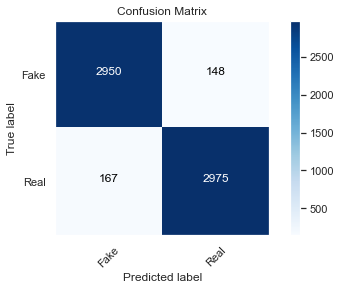

In [39]:
cm = metrics.confusion_matrix(Y_test, X_test_prediction1)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])
plt.grid(None)

In [40]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction1))

              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      3098
        Real       0.95      0.95      0.95      3142

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



#### Training  Model2 : Multinomial Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB

model2 = MultinomialNB()
model2.fit(X_train, Y_train)
X_train_prediction2 = model2.predict(X_train)
training_data_accuracy2 = accuracy_score(X_train_prediction2, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy2)

# Accuracy Score on Test Data
X_test_prediction2 = model1.predict(X_test)
test_data_accuracy2 = accuracy_score(X_test_prediction2, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy2)

Accuracy score on the training data:  0.908
Accuracy score on the test data:  0.950


Confusion matrix, without normalization


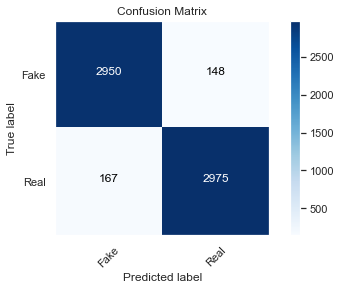

In [45]:
cm = metrics.confusion_matrix(Y_test, X_test_prediction2)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])
plt.grid(None)

In [47]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction2))

              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      3098
        Real       0.95      0.95      0.95      3142

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



#### Training  Model3 : Logistic Regression

In [48]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(X_train, Y_train)

X_train_prediction3 = model3.predict(X_train)
training_data_accuracy3 = accuracy_score(X_train_prediction3, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy3)

# Accuracy Score on Test Data
X_test_prediction3 = model3.predict(X_test)
test_data_accuracy3 = accuracy_score(X_test_prediction3, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy3)

Accuracy score on the training data:  0.968
Accuracy score on the test data:  0.939


Confusion matrix, without normalization


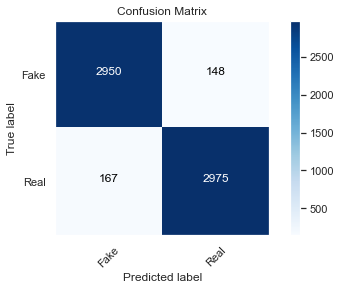

In [49]:
cm3 = metrics.confusion_matrix(Y_test, X_test_prediction3)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])
plt.grid(None)
#plt.axis('off')
#plt.rcParams["axes.grid"] = False

In [50]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction3))

              precision    recall  f1-score   support

        Fake       0.93      0.95      0.94      3098
        Real       0.95      0.93      0.94      3142

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



#### Training Model4 : Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier ()
model4.fit(X_train, Y_train)

X_train_prediction4 = model4.predict(X_train)
training_data_accuracy4 = accuracy_score(X_train_prediction4, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy4)

# Accuracy Score on Test Data
X_test_prediction4 = model4.predict(X_test)
test_data_accuracy4 = accuracy_score(X_test_prediction4, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy4)

Accuracy score on the training data:  1.000
Accuracy score on the test data:  0.916


Confusion matrix, without normalization


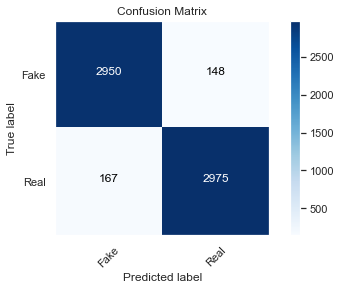

In [52]:
cm4 = metrics.confusion_matrix(Y_test, X_test_prediction4)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])
plt.grid(None)
#plt.axis('off')
#plt.rcParams["axes.grid"] = False

In [53]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction4))

              precision    recall  f1-score   support

        Fake       0.93      0.90      0.91      3098
        Real       0.90      0.93      0.92      3142

    accuracy                           0.92      6240
   macro avg       0.92      0.92      0.92      6240
weighted avg       0.92      0.92      0.92      6240



#### Training Model5 : Support Vector Machine

In [ ]:
from sklearn import svm
model5 = svm.SVC()
model5.fit(X_train, Y_train)

X_train_prediction5 = model5.predict(X_train)
training_data_accuracy5 = accuracy_score(X_train_prediction5, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy5)

# Accuracy Score on Test Data
X_test_prediction5 = model5.predict(X_test)
test_data_accuracy5 = accuracy_score(X_test_prediction5, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy5)

In [ ]:
cm4 = metrics.confusion_matrix(Y_test, X_test_prediction4)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])
plt.grid(None)
#plt.axis('off')
#plt.rcParams["axes.grid"] = False

##### Comparison of all algorithms Results

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
print('\n')
print("Comparison of all algorithm results")
x.field_names = ["Model", "Accuracy"]


x.add_row(["Passive Aggressive Classiifier", round(test_data_accuracy1,2)])
x.add_row(["Naive Bayes Algorithm", round(test_data_accuracy2,2)])
x.add_row(["LogisticRegression Algorithm", round(test_data_accuracy3,2)])
x.add_row(["Random Forest Algorithm", round(test_data_accuracy4,2)])
x.add_row(["Support Vector Machine", round(test_data_accuracy5,2)])

print(x)
print('\n')

# Making a Prediction

In [ ]:
X_new = X_test[1000:1005]

prediction = model1.predict(X_new)
print(prediction)

if (prediction[0] == 'Real'):
  print('The is Real News')
else:
  print('The news is Fake')

In [ ]:
data[1000:1005]

In [ ]:
import pandas as pd
test=pd.read_csv("C:/Users/ranja/Desktop/PROJECT1/test.csv")

In [ ]:
#stemmatize news titles
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []
for i in range(0, len(test)):
    
    if(pd.isnull(test["text"][i])):
        review=""
    else:
        review = re.sub('[^a-zA-Z]', ' ',test['text'][i])
        review = review.lower()
        review = review.split()

        review = [ps.stem(word) for word in review] # if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf.fit(X_test)
X_test = tfidf.transform(X_test)
# pred=model1.predict(X_test)


# #TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# vectorizer.fit(X)
# X = vectorizer.transform(X)

In [ ]:
type(X_test)

In [ ]:
pred=model1.predict(X_test)